In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
print(sns.__version__)

0.13.0


In [2]:
import pandas as pd

covid_data = pd.read_csv('C:\IDE\Skillfactory\PY-13 Visualisation\data\covid_19\\covid-19.csv', sep=',')
vaccinations_data = pd.read_csv('C:\IDE\Skillfactory\PY-13 Visualisation\data\covid_19\\country_vaccinations.csv')
vaccinations_data = vaccinations_data[
    ['country', 'date', 'total_vaccinations', 
     'people_vaccinated', 'people_vaccinated_per_hundred',
     'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
     'daily_vaccinations', 'vaccines']
]
covid_data['date'] = pd.to_datetime(covid_data['date'])
covid_data = covid_data.groupby(
    ['date', 'country'], 
    as_index=False
)[['confirmed', 'deaths', 'recovered']].sum()
covid_data['active'] = covid_data['confirmed'] - covid_data['deaths'] - covid_data['recovered']
covid_data = covid_data.sort_values(by=['country', 'date'])
covid_data['daily_confirmed'] = covid_data.groupby('country')['confirmed'].diff()
covid_data['daily_deaths'] = covid_data.groupby('country')['deaths'].diff()
covid_data['daily_recovered'] = covid_data.groupby('country')['recovered'].diff()
vaccinations_data['date'] = pd.to_datetime(vaccinations_data['date'])
covid_df = covid_data.merge(
    vaccinations_data,
    on = ['date', 'country'],
    how = 'left'
)
covid_df['death_rate'] = covid_df['deaths']/covid_df['confirmed']*100
covid_df['recover_rate'] = covid_df['recovered']/covid_df['confirmed']*100

In [3]:
# В данном разделе мы будем сравнивать несколько стран: Россию, Австралию, Германию, Канаду и Великобританию. 
# Создадим специальный DataFrame croped_covid_df для этих данных.

# Для фильтрации по списку значений используем метод isin(), который проверяет, есть ли запись в столбце в 
# переданном в метод списке. В результате возвращается привычная нам маска.

# ⭐ А теперь снова немного магии Feature Engineering, чтобы показатели по странам стали сопоставимыми: добавим 
# информацию о населении стран, чтобы рассчитать ежедневную заболеваемость на 100 человек — заболеваемость в 
# процентах от общего количества населения (daily_confirmed_per_hundred).

countries = ['Russia', 'Australia', 'Germany', 'Canada', 'United Kingdom']
croped_covid_df = covid_df[covid_df['country'].isin(countries)]

populations = pd.DataFrame([
    ['Canada', 37664517],
    ['Germany', 83721496],
    ['Russia', 145975300],
    ['Australia', 25726900],
    ['United Kingdom', 67802690]
    ],
    columns=['country', 'population']
)
croped_covid_df = croped_covid_df.merge(populations, on=['country'])
croped_covid_df['daily_confirmed_per_hundred'] = croped_covid_df['daily_confirmed'] / croped_covid_df['population'] * 100
croped_covid_df.head()

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered,total_vaccinations,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,daily_vaccinations,vaccines,death_rate,recover_rate,population,daily_confirmed_per_hundred
0,2020-01-23,Australia,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25726900,NaN
1,2020-01-25,Australia,4.0,0.0,0.0,4.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000016
2,2020-01-26,Australia,4.0,0.0,0.0,4.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000000
3,2020-01-27,Australia,5.0,0.0,0.0,5.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000004
4,2020-01-28,Australia,5.0,0.0,0.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000000


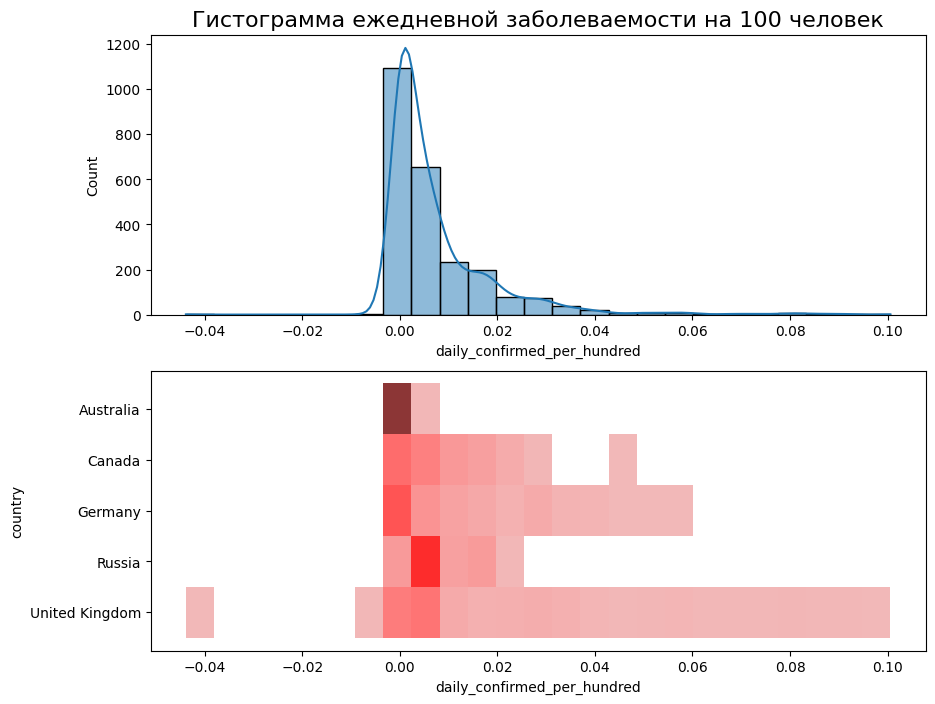

In [4]:
# Построим сразу две гистограммы: одна будет иллюстрировать общее распределение ежедневной заболеваемости (daily_confirmed), 
# а вторая — то же распределение в разрезе стран. 
# Для этого создаём две координатные плоскости с помощью метода subplots(). 
# На первой координатной плоскости рисуем простую гистограмму с 25 столбцами, а также добавим на неё сглаживающую кривую. 
# На второй гистограмме добавляем параметр названия страны по оси y. В таком случае количество наблюдений будет 
# обозначаться на диаграмме яркостью цвета (чем темнее полоса, тем больше наблюдений находится в интервале).

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.histplot(
    data=croped_covid_df,
    x='daily_confirmed_per_hundred',
    bins=25,
    kde=True,
    ax=axes[0]
);
axes[0].set_title('Гистограмма ежедневной заболеваемости на 100 человек', fontsize=16)
sns.histplot(
    data=croped_covid_df,
    x='daily_confirmed_per_hundred',
    y='country',
    bins=25,
    color='red',
    ax=axes[1]
);

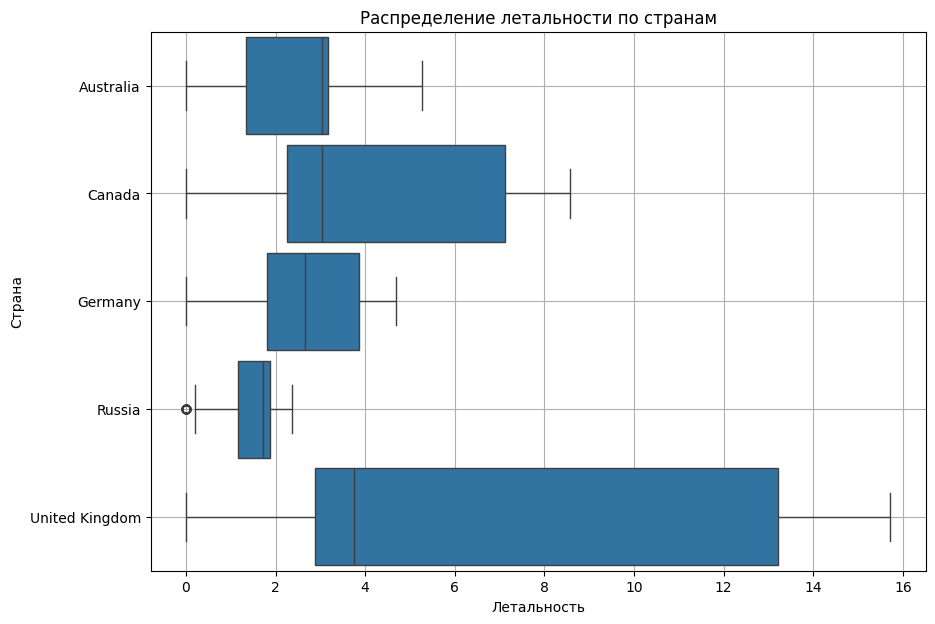

In [5]:
# Рассмотрим пример — построим коробчатые диаграммы признака летальности (death_rate).
# Коробчатые диаграммы в Seaborn строятся с помощью метода boxplot().
# Ящики отразим горизонтально (для этого по оси x отложим признак летальности, а по оси y — страны), 
# параметр orient отвечает за ориентацию диаграммы, а width — за ширину коробок:

fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data=croped_covid_df,
    y='country',
    x='death_rate',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение летальности по странам');
boxplot.set_xlabel('Летальность');
boxplot.set_ylabel('Страна');
boxplot.grid()

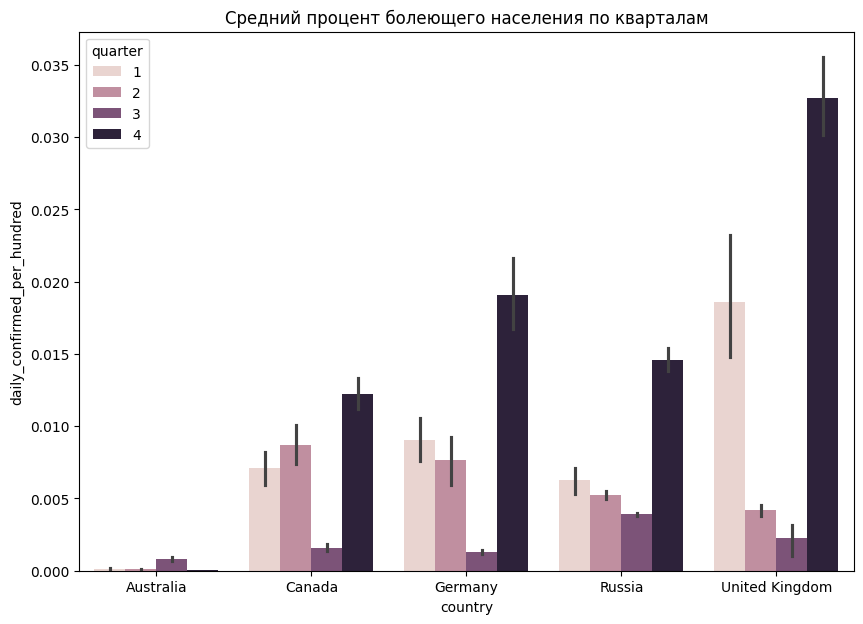

In [6]:
# Теперь рассмотрим пример многоуровневой столбчатой диаграммы. С помощью неё мы можем, например, посмотреть на 
# средний ежедневный процент заболевших в странах по кварталам.
# Для построения столбчатых диаграмм в Seaborn используется метод barplot(). По умолчанию метод отображает среднее 
# по столбцу, который указан в параметре x (вместо среднего можно вычислить и любую другую статистическую 
# характеристику, наименование которой задаётся в параметре estimator). Для добавления многоуровневости используется 
# параметр hue, который позволяет группировать данные по признаку:

fig = plt.figure(figsize=(10, 7))
croped_covid_df['quarter'] = croped_covid_df['date'].dt.quarter
barplot = sns.barplot(
    data=croped_covid_df,
    x='country',
    y='daily_confirmed_per_hundred',
    hue='quarter',
)
barplot.set_title('Средний процент болеющего населения по кварталам');

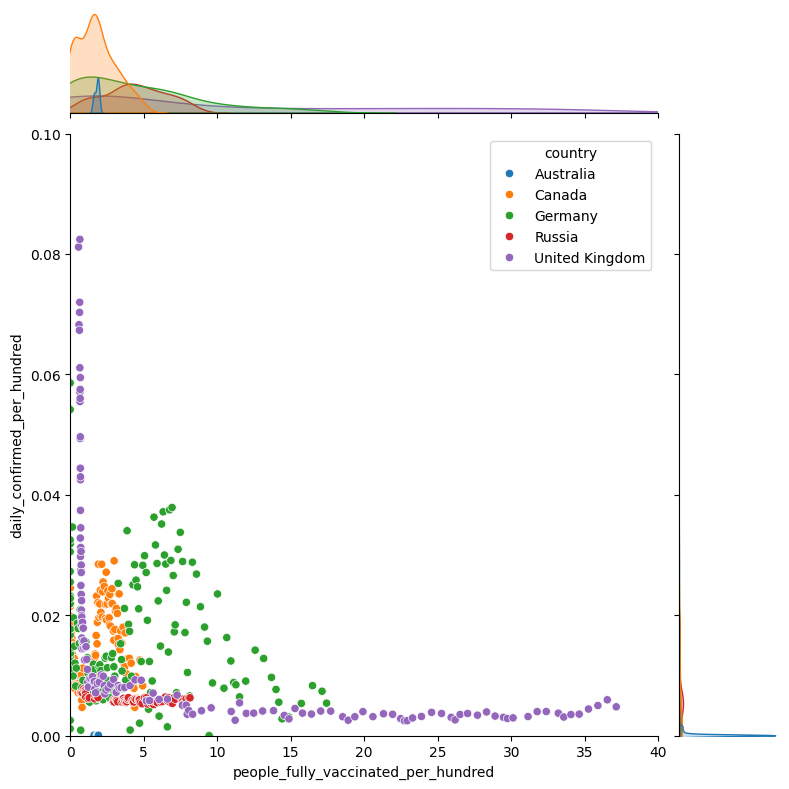

In [7]:
# Построим jointplot зависимости ежедневной заболеваемости в странах от общей численности населения в процентах 
# (daily_confirmed_per_hundred) от числа полностью вакцинированных в процентах (people_fully_vaccinated_per_hundred).
# Параметры xlim и ylim определяют диапазон отображения осей x и y. Параметр height отвечает за высоту и ширину графика 
# (он квадратный).

jointplot = sns.jointplot(
    data=croped_covid_df, 
    x='people_fully_vaccinated_per_hundred', 
    y='daily_confirmed_per_hundred',
    hue='country',
    xlim = (0, 40),
    ylim = (0, 0.1),
    height=8
)

In [8]:
# Допустим, мы хотим сравнить темпы вакцинации по странам во времени. Вы, скорее всего, сразу подумали о 
# линейном графике. Но давайте мыслить шире. Когда мы хотим сравнить скорость изменения показателей по малому 
# количеству категорий (в данном случае — по странам, а их у нас их всего пять), нагляднее всего будет тепловая карта.
# Предварительно создадим сводную таблицу: по столбцам отложим признак даты, а по строкам — страны. В ячейках 
# таблицы будет находиться процент вакцинированных (первым компонентом) людей в стране на определённую дату. 
# Чтобы даты отображались на тепловой карте верно, их необходимо привести к типу string.

pivot = croped_covid_df.pivot_table(
    values='people_vaccinated_per_hundred',
    columns='date',
    index='country',
)
pivot.columns = pivot.columns.astype('string')
display(pivot)

date,2020-12-13,2020-12-14,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-19,2020-12-20,2020-12-21,2020-12-22,...,2021-05-20,2021-05-21,2021-05-22,2021-05-23,2021-05-24,2021-05-25,2021-05-26,2021-05-27,2021-05-28,2021-05-29
country,,,,,,,,,,,,,,,,,,,,,
Australia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,12.40,12.69,12.88,13.28,13.73,14.18
Canada,NaN,0.0,0.00,0.01,0.02,0.03,0.03,0.03,0.05,0.07,...,48.10,49.25,50.14,50.89,51.77,52.39,53.05,53.95,54.99,55.71
Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.18,39.68,39.95,40.11,40.29,40.64,41.29,41.87,42.40,42.61
Russia,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,0.04,...,10.20,10.30,10.50,10.53,10.70,10.81,11.07,11.12,11.19,11.29
United Kingdom,0.13,NaN,NaN,NaN,NaN,NaN,NaN,0.99,NaN,NaN,...,55.01,55.33,55.63,55.82,55.99,56.27,56.61,56.99,57.29,57.56


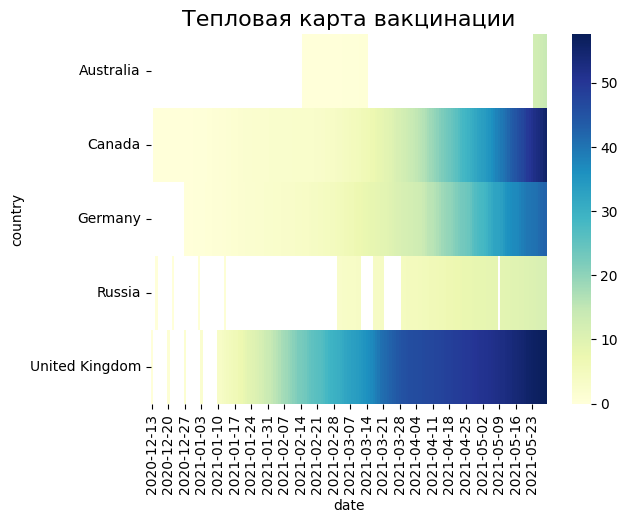

In [9]:
# Для построения тепловой карты в Seaborn используется метод heatmap(). Данный метод работает с табличными данными 
# и визуализирует все ячейки таблицы с помощью цвета. Параметр annot отвечает за отображение легенды (аннотации), 
# параметр cmap — за цветовую гамму графика.

heatmap = sns.heatmap(data=pivot, cmap='YlGnBu')
heatmap.set_title('Тепловая карта вакцинации', fontsize=16);

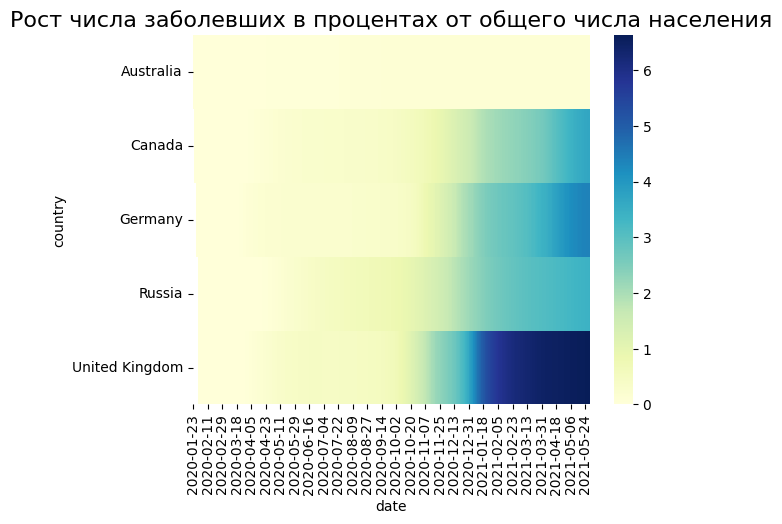

In [10]:
# Создайте новый признак confirmed_per_hundred, который покажет процентное отношение заболевших вирусом к общему числу населения в странах ().
# Постройте тепловую карту, которая покажет, как росло число заболевших в процентах от общего числа населения (confirmed_per_hundred) в странах
# из таблицы croped_covid_df.

croped_covid_df['confirmed_per_hundred'] = croped_covid_df['confirmed'] / croped_covid_df['population'] * 100

pivot = croped_covid_df.pivot_table(
    values='confirmed_per_hundred',
    columns='date',
    index='country'
)
pivot.columns = pivot.columns.astype('string')

heatmap = sns.heatmap(data=pivot, cmap='YlGnBu');
heatmap.set_title('Рост числа заболевших в процентах от общего числа населения', fontsize=16);

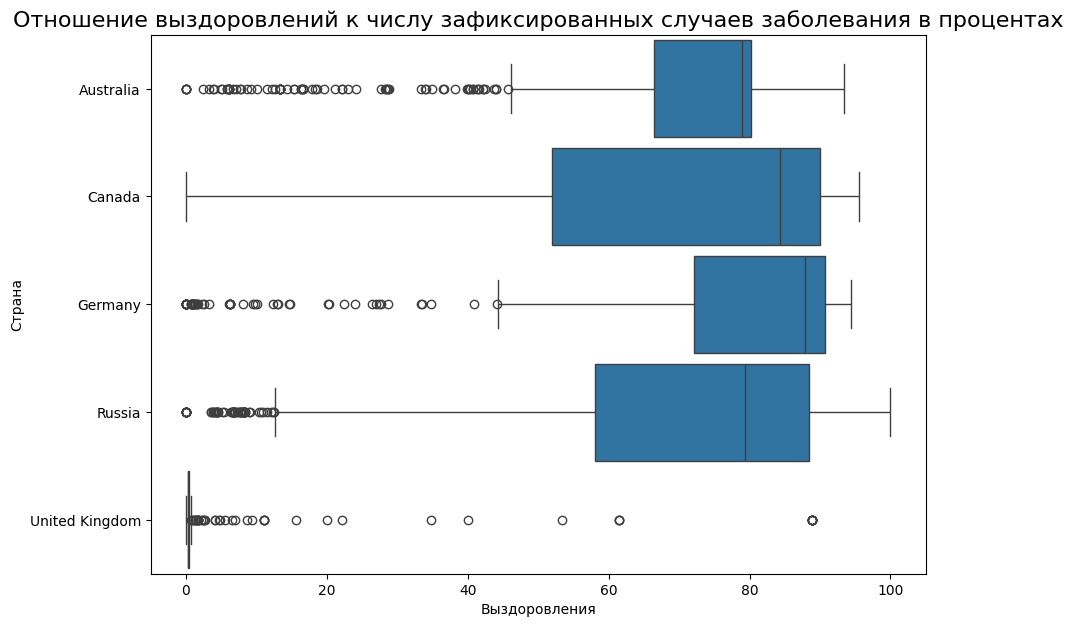

In [11]:
# Постройте коробчатую диаграмму для признака recover_rate (отношение выздоровлений к числу зафиксированных случаев заболевания в процентах).

fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data=croped_covid_df,
    y='country',
    x='recover_rate',
    orient='h',
    width=0.9
)
boxplot.set_title('Отношение выздоровлений к числу зафиксированных случаев заболевания в процентах', fontsize=16);
boxplot.set_xlabel('Выздоровления');
boxplot.set_ylabel('Страна');